In [7]:
#import
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

os.makedirs("results", exist_ok=True)

##dataset
ds = load_dataset("ag_news")

# train/val split
split   = ds["train"].train_test_split(
    test_size=0.1, seed=42, stratify_by_column="label"
)
train_ds = split["train"]
val_ds   = split["test"]
test_ds  = ds["test"]

print(train_ds)
print(val_ds)

_df = pd.DataFrame({"text": train_ds["text"], "label": train_ds["label"]})
_sub = _df.groupby("label", group_keys=False).apply(
    lambda g: g.sample(n=5000, random_state=42)
)
train_small = Dataset.from_pandas(_sub.reset_index(drop=True), preserve_index=False)
print(train_small)


Dataset({
    features: ['text', 'label'],
    num_rows: 108000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 12000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 20000
})


/tmp/ipython-input-3184082216.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _sub = _df.groupby("label", group_keys=False).apply(


##Learning Curve（TF-IDF word 1–2 gram）

In [8]:
#Learning Curve for TF-IDF + LinearSVC
sizes = [1000, 5000, 10000, len(train_ds)]
results_lc = []

for n in sizes:
    _df = pd.DataFrame({"text": train_ds["text"], "label": train_ds["label"]})
    sub = _df.groupby("label", group_keys=False).apply(
        lambda g: g.sample(n // 4, random_state=42)
    )
    sub_ds = Dataset.from_pandas(sub, preserve_index=False)

    X_tr, y_tr = sub_ds["text"], sub_ds["label"]
    X_va, y_va = val_ds["text"], val_ds["label"]

    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2,
                            max_features=100_000, lowercase=True)
    Xtr = tfidf.fit_transform(X_tr)
    Xva = tfidf.transform(X_va)

    clf = LinearSVC(random_state=42)
    clf.fit(Xtr, y_tr)

    pred = clf.predict(Xva)
    acc = accuracy_score(y_va, pred)
    mf1 = f1_score(y_va, pred, average="macro")

    results_lc.append({"n": n, "accuracy": acc, "macro_f1": mf1})
    print(n, acc, mf1)

df_lc = pd.DataFrame(results_lc)
df_lc.to_csv("results/lc_tfidf.csv", index=False)
with open("results/lc_tfidf.json", "w") as f:
    json.dump(results_lc, f, indent=2)

df_lc


/tmp/ipython-input-3429218504.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub = _df.groupby("label", group_keys=False).apply(


1000 0.8306666666666667 0.8299503743461221


/tmp/ipython-input-3429218504.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub = _df.groupby("label", group_keys=False).apply(


5000 0.8861666666666667 0.8856290112024383


/tmp/ipython-input-3429218504.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub = _df.groupby("label", group_keys=False).apply(


10000 0.8980833333333333 0.897695744871223


/tmp/ipython-input-3429218504.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub = _df.groupby("label", group_keys=False).apply(


108000 0.92225 0.9221076079813807


,n,accuracy,macro_f1
0,1000,0.830667,0.829950
1,5000,0.886167,0.885629
2,10000,0.898083,0.897696
3,108000,0.922250,0.922108


## Visualiztion

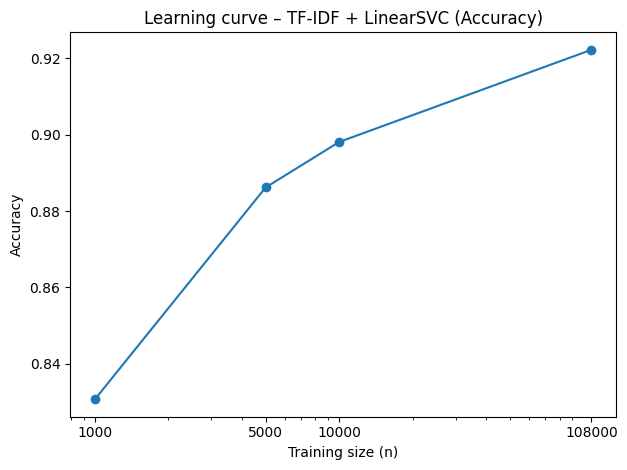

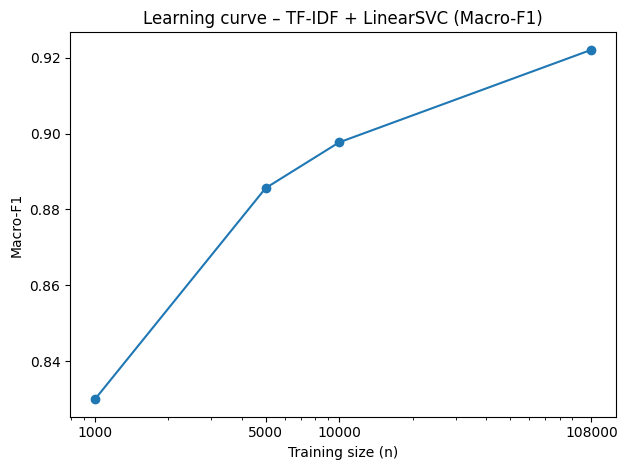

In [9]:
# Accuracy curve
plt.figure()
plt.plot(df_lc["n"], df_lc["accuracy"], marker="o")
plt.xscale("log")
plt.xticks(df_lc["n"], df_lc["n"])
plt.xlabel("Training size (n)")
plt.ylabel("Accuracy")
plt.title("Learning curve – TF-IDF + LinearSVC (Accuracy)")
plt.tight_layout()
plt.savefig("results/lc_tfidf_acc.png", dpi=300)
plt.show()

# Macro-F1 curve
plt.figure()
plt.plot(df_lc["n"], df_lc["macro_f1"], marker="o")
plt.xscale("log")
plt.xticks(df_lc["n"], df_lc["n"])
plt.xlabel("Training size (n)")
plt.ylabel("Macro-F1")
plt.title("Learning curve – TF-IDF + LinearSVC (Macro-F1)")
plt.tight_layout()
plt.savefig("results/lc_tfidf_f1.png", dpi=300)
plt.show()


##Baseline 1: TF-IDF word 1–2 gram（full train_small）

In [10]:
X_tr, y_tr = train_small["text"], train_small["label"]
X_va, y_va = val_ds["text"], val_ds["label"]

tfidf = TfidfVectorizer(
    ngram_range=(1,2), min_df=2,
    max_features=100_000, lowercase=True
)
Xtr = tfidf.fit_transform(X_tr)
Xva = tfidf.transform(X_va)

clf = LinearSVC(random_state=42)
clf.fit(Xtr, y_tr)

pred = clf.predict(Xva)
acc = accuracy_score(y_va, pred)
mf1 = f1_score(y_va, pred, average="macro")

baseline1 = {"accuracy": acc, "macro_f1": mf1}
baseline1

{'accuracy': 0.91, 'macro_f1': 0.9097404519738107}

##Baseline 2: TF-IDF word + character n-gram

In [11]:
tfidf_wchar = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(3,5),
    min_df=3,
    max_features=200_000
)
Xtr_wc = tfidf_wchar.fit_transform(X_tr)
Xva_wc = tfidf_wchar.transform(X_va)

clf_wc = LinearSVC(random_state=42)
clf_wc.fit(Xtr_wc, y_tr)

pred_wc = clf_wc.predict(Xva_wc)
acc_wc = accuracy_score(y_va, pred_wc)
mf1_wc = f1_score(y_va, pred_wc, average="macro")

baseline2 = {"accuracy": acc_wc, "macro_f1": mf1_wc}
baseline2

{'accuracy': 0.9023333333333333, 'macro_f1': 0.9021464499205551}

##Error analysis for TF-IDF

In [12]:
y_true = y_va
y_pred = pred_wc

texts = val_ds["text"]

idx_bs = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred)) if yt == 2 and yp == 3][:3]

idx_sb = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred)) if yt == 3 and yp == 2][:3]

print("Business (true) → Sci/Tech (pred):")
for i in idx_bs:
    print("----")
    print(texts[i])
    print("true=Business, pred=Sci/Tech")

print("\nSci/Tech (true) → Business (pred):")
for i in idx_sb:
    print("----")
    print(texts[i])
    print("true=Sci/Tech, pred=Business")


Business (true) → Sci/Tech (pred):
----
EPA could reject appeal, order Wednesday that Metro Detroit cars &lt;b&gt;...&lt;/b&gt; The Environmental Protection Agency is expected to decide by Wednesday whether automobile emissions tests could be mandatory for communities in the metropolitan area.
true=Business, pred=Sci/Tech
----
Fujitsu and Cisco Form Strategic Alliance SAN JOSE, Calif.  amp; TOKYO - (BUSINESS WIRE) -ec. 5, 2004  -itsu Limited (TSE:6702) and Cisco Systems, Inc. (NASDAQ:CSCO) today announced that they have reached a fundamental agreement to enter into 
true=Business, pred=Sci/Tech
----
CA Taps IBM Vet John Swainson As CEO Swainson, a 26-year IBMer, most recently led the worldwide sales organization for the company #39;s software group. He replaces interim CEO Kenneth Cron.
true=Business, pred=Sci/Tech

Sci/Tech (true) → Business (pred):
----
Monti: Courts must rule on MS anti-trust Mario Monti, the outgoing European competition commissioner, has told Microsoft that  quot;

##Confusion Matrix (TF-IDF Word+Char)

<Figure size 520x440 with 0 Axes>

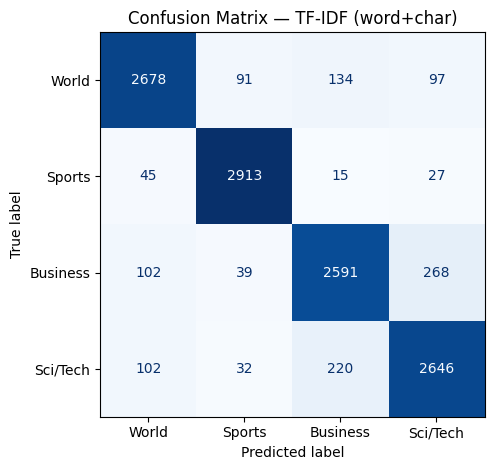

In [13]:
labels4 = ["World","Sports","Business","Sci/Tech"]
cm = confusion_matrix(y_va, pred_wc, labels=[0,1,2,3])

disp = ConfusionMatrixDisplay(cm, display_labels=labels4)
plt.figure(figsize=(5.2, 4.4))
disp.plot(cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix — TF-IDF (word+char)")
plt.tight_layout()
plt.savefig("results/confmat_tfidf_word_char.png", dpi=300)
plt.show()